In [1]:
# --- MUST be first matplotlib cell in the notebook ---
import matplotlib
matplotlib.use('nbAgg')              # interactive backend for classic Notebook 5.x
%matplotlib notebook
print("Matplotlib backend:", matplotlib.get_backend())


Matplotlib backend: nbAgg


In [2]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
# tf.disable_eager_execution()
import PIL.Image
#%matplotlib inline
#import matplotlib.pyplot as plt

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


##### Set the path of code folder containing GANSim codes

In [4]:
new_path = r'/home/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DPointBar/2_GANSimTraining/' 
sys.path.append(new_path)

### 1. Load test dataset

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [5]:
data_dir_test = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/PreparedDataset/'

In [6]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset

test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = True, cond_prob = True,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

test_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 0)  
facies_test = test_dict['real']
labels_test = test_dict['label']
probimgs_test = test_dict['prob']
wellfaciesimgs_test = test_dict['well']

# loaded labels (global features) have been normalized into -1 to 1
# Denormalize the global features back into its orginal range 
pb_cf_ratio = labels_test[:, 0] # pb_cf_ratio has been normalized
pb_cf_ratio = (pb_cf_ratio / 2 + 0.5) * (2 - 0.2) + 0.2
fp_prop = labels_test[:, 1] # fp_prop has been normalized
fp_prop = (fp_prop / 2 + 0.5) * (0.82 - 0.5) + 0.5

print(facies_test.shape)
print(pb_cf_ratio.shape)
print(fp_prop.shape)
print(probimgs_test.shape)
print(wellfaciesimgs_test.shape)

Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
(1000, 1, 64, 64)
(1000,)
(1000,)
(1000, 3, 64, 64)
(1000, 1, 64, 64)


In [7]:
# In the test and training facies models, the facies codes are 0, 1, 3, and 4, corresponding to the four facies types.
# The generator produces facies indicator models, which are then converted into facies models using an argmax function.
# As a result, the generated facies models have codes 0, 1, 2, and 3.
# To facilitate comparison between the test and generated facies models, the test facies codes are also remapped to 0, 1, 2, and 3.

facies_test_newcode = np.where(facies_test>2, facies_test-1, facies_test)

In [8]:
# Correspondingly, in the training/test dataset, the well facies data have the codes of 0 (non-well), 1 (floodplain facies), 2 (mud drape)
# 4 (abandoned channels), and 5 (sandy lateral accretion). Now, they are also converted into 0, 1, 2, 3, 4.

wellfaciesimgs_test_newcode = np.where(wellfaciesimgs_test>3, wellfaciesimgs_test-1, wellfaciesimgs_test)

### (1) Load trained generator

In [9]:
GANSim_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/GANSim_cond_gf_well_prob/'
GANSim_name = 'network-snapshot-026560.pkl'   # 13440

In [10]:
# Initialize TensorFlow session.
tf.InteractiveSession()

with tf.device('/gpu:0'):   
    # Import networks.
    with open(GANSim_dir + GANSim_name, 'rb') as file:
        G, D, Gs_Gansim = pickle.load(file)
    

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### UI

<IPython.core.display.Javascript object>


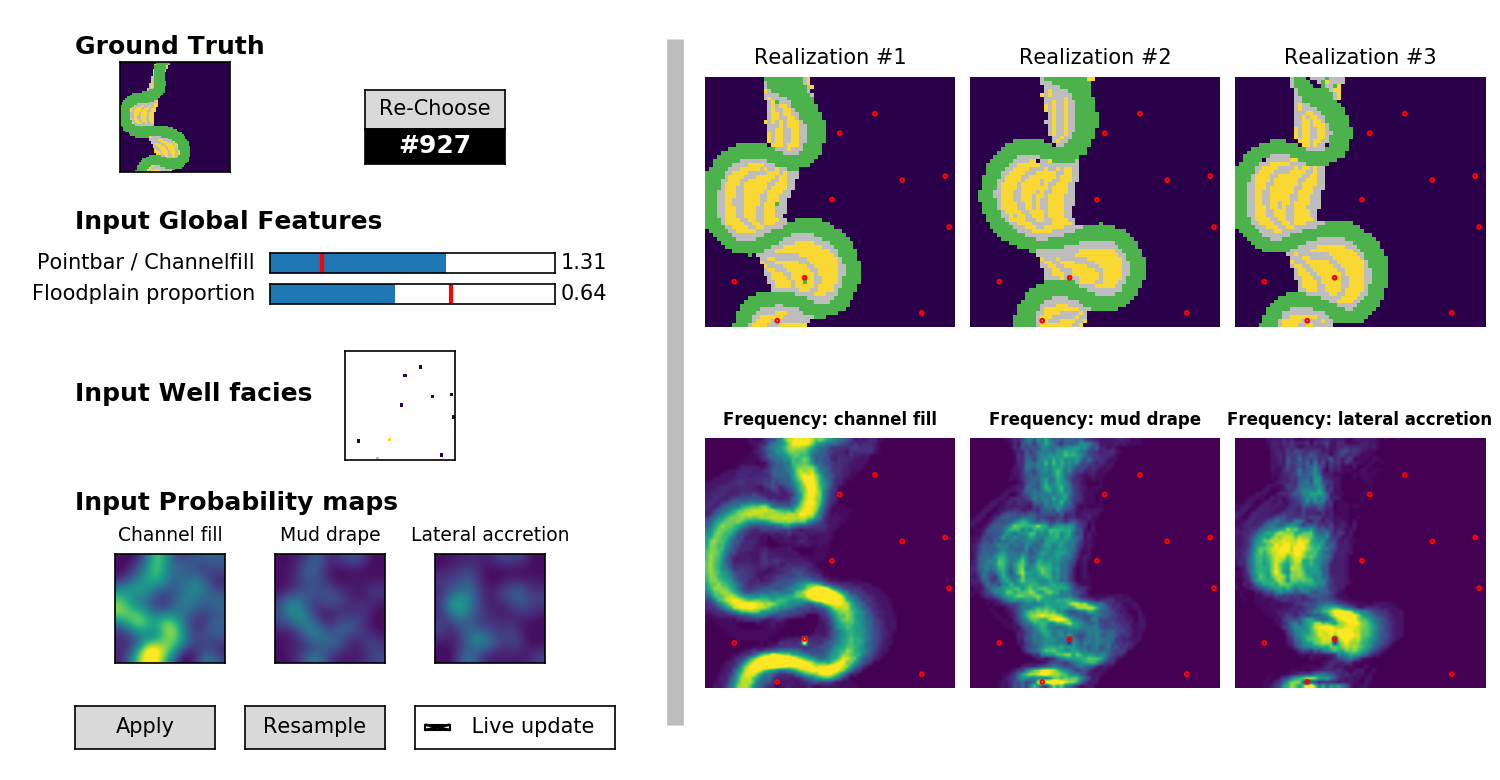

In [20]:
# ==== Imports ====
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, CheckButtons
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

# ======================= Dataset / Model knobs =======================
# Make sure these exist from your 2DPointBar notebook:
# facies_test_newcode:   (N,1,64,64)   integer classes {1..C}
# labels_test:   (N,>=34)      one-hot(30) + 4 normalized globals
# probimgs_test: (N,2,64,64)   [pointbar, overbank] probabilities in [0,1]
# Gs_Gansim:     trained PointBar generator

# Number of facies classes (0..C-1 after shifting; typically 3: bg/overbank/pointbar)
C = 4

# Latent tensor shape for your PointBar generator:
Z_SHAPE = (8, 4, 4)   # <-- change to (8,4,4) if your model uses that

# How many realizations per forward pass (single GANSim run)
K_SAMPLES = 50

# ======================= Helpers (normalization) =====================
def norm_features(pb_cf_ratio, fp_prop):
    fp_prop_n = ((fp_prop - 0.5) / (0.82 - 0.5) - 0.5) * 2
    pb_cf_ratio_n   = ((pb_cf_ratio - 0.2) / (2 - 0.2) - 0.5) * 2
    return pb_cf_ratio_n, fp_prop_n

def inv_norm_features(pb_cf_ratio_n, fp_prop_n):
    pb_cf_ratio = (pb_cf_ratio_n / 2 + 0.5) * (2 - 0.2) + 0.2
    fp_prop = (fp_prop_n / 2 + 0.5) * (0.82 - 0.5) + 0.5
    return pb_cf_ratio, fp_prop

# ---- PointBar globals: 2 features -> map to (B,2,H,W) ----
def build_label(pb_cf_ratio, fp_prop):
    pb_cf_n, fp_n = norm_features(pb_cf_ratio, fp_prop)
    # shape (2,) – not 34 anymore
    return np.array([pb_cf_n, fp_n], dtype=np.float32)

def vector_to_maps(label_vec, H=64, W=64, B=4):
    # label_vec shape (2,), -> (2,H,W) -> (B,2,H,W)
    lab_hw = np.broadcast_to(label_vec[:, None, None],
                             (label_vec.shape[0], H, W)).astype(np.float32)
    return np.broadcast_to(lab_hw[None, ...],
                           (B, lab_hw.shape[0], H, W)).copy()

# ---- 2x2 enlargement (NumPy) ----
def _shift(mask, di, dj):
    out = np.zeros_like(mask, dtype=bool)
    i0 = max(0, di); i1 = mask.shape[0] + min(0, di)
    j0 = max(0, dj); j1 = mask.shape[1] + min(0, dj)
    out[i0:i1, j0:j1] = mask[i0-di:i1-di, j0-dj:j1-dj]
    return out

def enlarge_2x2_wells(wells_1p, n_classes=C):
    """wells_1p: (2,H,W) [loc 0/1, facies_id 0..K-1] → 2×2 dilation."""
    loc = wells_1p[0] > 0.5
    fc  = wells_1p[1].astype(np.int32)
    loc_big = (loc | _shift(loc,1,0) | _shift(loc,0,1) | _shift(loc,1,1))
    fc_big = np.zeros_like(fc)
    for c_ in range(n_classes):
        m = (fc==c_) & loc
        m_big = (m | _shift(m,1,0) | _shift(m,0,1) | _shift(m,1,1))
        fc_big[m_big] = c_
    return np.stack([loc_big.astype(np.float32), fc_big.astype(np.float32)], axis=0)

# ======================= Batch / geometry / colors ===================
rng = np.random.RandomState(412)
B, H, W = 4, 64, 64  # B here is just the default for vector_to_maps

# Facies colors (order must match your class ids 0..3):
# 0 = background mud (purple), 1 = channel fill (green),
# 2 = point-bar sand (yellow), 3 = point-bar mud drape (gray)
bg_purple   = '#2b004b'     # deep purple background
channel_grn = [0.30, 0.70, 0.30]
pb_sand_y   = [0.98, 0.85, 0.20]
pb_mud_gray = '#bdbdbd'

facies_cmap = ListedColormap([bg_purple, pb_mud_gray, channel_grn, pb_sand_y])
facies_cmap_well = ListedColormap([bg_purple, pb_mud_gray, channel_grn, pb_sand_y])
facies_cmap_well.set_bad(color='white')  # non-well area shown as white in the well panel
prob_cmap = plt.cm.viridis

# ======================= Fixed latent pool (per UI session) =========
LATENT_SEED = rng.randint(0, 1_000_000)

# ======================= cache vars (3 freqs; 3 shown realizations) =============
LATENT_SEED = rng.randint(0, 1_000_000)
def _build_latent_pool(seed):
    rs = np.random.RandomState(int(seed))
    return rs.randn(K_SAMPLES, *Z_SHAPE).astype(np.float32)
latents_pool = _build_latent_pool(LATENT_SEED)
ridx_triplet = rng.choice(K_SAMPLES, size=3, replace=False)

last_cls      = None
last_freq_cf  = None   # class 2: channel fill
last_freq_md  = None   # class 1: mud drape
last_freq_la  = None   # class 3: lateral accretion (pointbar sand)

# ======================= Dataset hooks ===============================
N_TEST = facies_test.shape[0]   # expects (N,1,64,64)

def sample_wells_from_gt(gt_map_12, ssd=1):
    wp = np.zeros((1, 1, H, W), dtype=np.int8)
    npts = np.random.RandomState(3 * ssd + ssd * ssd).choice(np.arange(1, 11), 1)[0]
    xs   = np.random.RandomState(123 * ssd).choice(H, npts)
    ys   = np.random.RandomState(3 * ssd + ssd * ssd).choice(W, npts)
    wp[0, 0, xs, ys] = 1
    wf  = gt_map_12[None, None, :, :] * wp
    wf  = wf + wp
    loc = (wf > 0).astype(np.float32)
    fc  = (wf - 1) * loc
    return np.concatenate([loc, fc], axis=1)[0]  # (2,H,W)

def get_prob_pair(idx):
    """Return (prob_pointbar, prob_overbank) each (64,64) in [0,1]."""
    arr = probimgs_test[idx]  # PointBar notebook uses [pointbar, overbank]
    if arr.shape[0] >= 3:
        prob_md = arr[0].astype(np.float32)  # mud drape facies 
        prob_cf = arr[1].astype(np.float32)  # channel fill facies
        prob_la = arr[2].astype(np.float32)  # lateral accretion sand facies
        
    else:
        prob_md = np.zeros((H,W), np.float32)
        prob_cf = np.zeros((H,W), np.float32)
        prob_la = np.zeros((H,W), np.float32)
    return prob_md, prob_cf, prob_la

def gt_globals_from_labels(idx):
    """Return (pb_cf_ratio, fp_prop) in real units using inverse-normalization."""
    lab = labels_test[idx]
    # assume first two entries are normalized [pb_cf_ratio_n, fp_prop_n]
    pb_cf_ratio, fp_prop = inv_norm_features(float(lab[0]), float(lab[1]))
    return pb_cf_ratio, fp_prop


# ======================= Figure & layout ============================
fig, axes = plt.subplots(2, 3, figsize=(10, 5.2))   # 2 rows × 3 cols on the RIGHT
plt.subplots_adjust(left=0.47, right=0.99, bottom=0.06, top=0.96, hspace=0.06, wspace=0.06)
for ax in axes.flat: ax.axis('off')

# Left panel geometry
x_panel, w_panel = 0.05, 0.34
def _label(ax_rect, text, size=10, bold=False, align='left'):
    ax = plt.axes(ax_rect, frameon=False); ax.set_xticks([]); ax.set_yticks([])
    ax.text(0.0 if align=='left' else 1.0, 0.5, text,
            ha=align, va='center', fontsize=size, fontweight=('bold' if bold else 'normal'))
    return ax

# --- Ground Truth section ---
_label([x_panel, 0.925, w_panel, 0.03], 'Ground Truth', size=12, bold=True, align='left')
tile_h = 0.14
tile_w = (w_panel - 0.06) / 3.0

ax_gt   = plt.axes([x_panel + 0.02,               0.78,  tile_w, tile_h]); ax_gt.set_xticks([]); ax_gt.set_yticks([])
ax_gtbtn= plt.axes([x_panel + 0.1 + tile_w,       0.835, tile_w*1.0, 0.05])
ax_gtbox= plt.axes([x_panel + 0.1 + tile_w,       0.790, tile_w*1.0, 0.045], facecolor='black')
ax_gtbox.set_xticks([]); ax_gtbox.set_yticks([])
btn_rechoose = Button(ax_gtbtn, 'Re-Choose')
def _set_sample_box(idx):
    ax_gtbox.clear()
    ax_gtbox.set_facecolor('black'); ax_gtbox.set_xticks([]); ax_gtbox.set_yticks([])
    ax_gtbox.text(0.5, 0.5, f'#{idx}', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

# Divider
fig.add_artist(Line2D([0.45, 0.45], [0.07, 0.95], transform=fig.transFigure,
                      color='#bdbdbd', linewidth=8, solid_capstyle='butt', zorder=3))



# --- Input Global Features (right-aligned labels, tight gaps) ---
_label([x_panel, 0.70, w_panel, 0.03], 'Input Global Features', size=12, bold=True, align='left')
w_label = 0.12; gap = 0.010
w_slider = w_panel - w_label - gap - 0.02
y = 0.65; row_h, row_gap = 0.026, 0.040
def _rlabel(ypos, text):
    _label([x_panel, ypos, w_label, row_h], text, size=10, align='right')
    return plt.axes([x_panel + w_label + gap, ypos, w_slider, row_h])

ax_pb_cf   = _rlabel(y, 'Pointbar / Channelfill'); y -= row_gap
ax_fp_prop = _rlabel(y, 'Floodplain proportion')

s_pb_cf   = Slider(ax_pb_cf,   '', 0.20, 2.00, valinit=1.00, valstep=0.01)
s_fp_prop = Slider(ax_fp_prop, '', 0.50, 0.82, valinit=0.65, valstep=0.01)

def _mark_slider(slider, gt_val):
    try: slider.vline.set_visible(False)
    except Exception: pass
    if hasattr(slider, "_marks"):
        for ln in slider._marks:
            try: ln.remove()
            except Exception: pass
    slider._marks = []
    slider._marks.append(slider.ax.axvline(gt_val, color='red', lw=2))
    
# --- NEW: Well facies on its own line ---
_label([x_panel, 0.48, w_panel, 0.03], 'Input Well facies', size=12, bold=True, align='left')
row_y_well = 0.41
ax_well = plt.axes([0.22, row_y_well, tile_w, tile_h]); ax_well.set_xticks([]); ax_well.set_yticks([])
#ax_well.set_title('Wells (2×2 enlarged)', fontsize=9)

# --- NEW: Probability maps on a separate line (CF → MD → LA) ---
_label([x_panel, 0.34, w_panel, 0.03], 'Input Probability maps', size=12, bold=True, align='left')
row_y_prob = 0.15
pad_x = 0.02
tile_w3 = (w_panel - 4*pad_x) / 3.0
ax_pCF  = plt.axes([x_panel + pad_x,                     row_y_prob, tile_w3, tile_h]); ax_pCF.set_xticks([]);  ax_pCF.set_yticks([])
ax_pMD  = plt.axes([x_panel + 2*pad_x + 1*tile_w3,       row_y_prob, tile_w3, tile_h]); ax_pMD.set_xticks([]);  ax_pMD.set_yticks([])
ax_pLA  = plt.axes([x_panel + 3*pad_x + 2*tile_w3,       row_y_prob, tile_w3, tile_h]); ax_pLA.set_xticks([]);  ax_pLA.set_yticks([])
ax_pCF.set_title('Channel fill',    fontsize=9)
ax_pMD.set_title('Mud drape',       fontsize=9)
ax_pLA.set_title('Lateral accretion', fontsize=9)

# placeholders for left previews
gt_img   = ax_gt.imshow(np.zeros((H,W)), cmap=facies_cmap,      vmin=0, vmax=C-1, interpolation='nearest')
well_img = ax_well.imshow(np.zeros((H,W)), cmap=facies_cmap_well,vmin=0, vmax=C-1, interpolation='nearest')
pCF_img  = ax_pCF.imshow(np.zeros((H,W)),  vmin=0, vmax=0.5, cmap=prob_cmap, interpolation='bilinear')
pMD_img  = ax_pMD.imshow(np.zeros((H,W)),  vmin=0, vmax=0.5, cmap=prob_cmap, interpolation='bilinear')
pLA_img  = ax_pLA.imshow(np.zeros((H,W)),  vmin=0, vmax=0.5, cmap=prob_cmap, interpolation='bilinear')


# Bottom row: Apply | Resample | Live update
bx = x_panel; bw = (w_panel - 0.06)/3.0; by = 0.04; bh = 0.055
ax_apply  = plt.axes([bx,             by, bw, bh])
ax_resamp = plt.axes([bx + bw + 0.02, by, bw, bh])
ax_live   = plt.axes([bx + 2*bw + 0.04, by, bw+0.04, bh])
btn_apply  = Button(ax_apply,  'Apply')
btn_resamp = Button(ax_resamp, 'Resample')
chk_live   = CheckButtons(ax_live, [' Live update'], [True])
live = True
def _toggle_live(_label):
    global live
    live = not live
chk_live.on_clicked(_toggle_live)

# ======================= State & placeholders ========================
test_idx  = 0
well_seed = 1

gt_img   = ax_gt.imshow(np.zeros((H,W)), cmap=facies_cmap, vmin=0, vmax=C-1, interpolation='nearest')

def _labels_batch():
    label_vec = build_label(s_pb_cf.val, s_fp_prop.val)   # <- two sliders
    return vector_to_maps(label_vec, H, W, B)             # -> (B,2,H,W)

# ======================= condition builders (unchanged except order) ============
def _cond_batches_from_inputs(gt_idx, well_seed):
    gt_12 = facies_test_newcode[gt_idx, 0].astype(np.int32)      # 0..C-1 expected
    gt_02 = np.clip(gt_12, 0, C-1).astype(np.int32)
    wells_1p = sample_wells_from_gt(gt_12, ssd=well_seed * gt_idx + 33)
    # NOTE: returns (prob_md, prob_cf, prob_la)
    prob_md, prob_cf, prob_la = get_prob_pair(gt_idx)
    wells_b = np.broadcast_to(wells_1p[None, ...], (B, 2, H, W)).astype(np.float32).copy()
    # 3-channel probability conditioning in order [CF, MD, LA] for the UI,
    # but keep any order here that your model expects. If your G expects [md, cf, la],
    # leave the stack as below; only the *display* order changed.
    prob_3 = np.stack([prob_md, prob_cf, prob_la], axis=0)   # adjust if your model needs a different order
    prob_b = np.broadcast_to(prob_3[None, ...], (B, 3, H, W)).astype(np.float32).copy()
    return gt_02, wells_1p, prob_md, prob_cf, prob_la, wells_b, prob_b


def _update_sliders_with_gt(idx):
    pb_cf_ratio, fp_prop = gt_globals_from_labels(idx)
    s_pb_cf.set_val(np.clip(pb_cf_ratio, s_pb_cf.valmin, s_pb_cf.valmax))
    s_fp_prop.set_val(np.clip(fp_prop,   s_fp_prop.valmin, s_fp_prop.valmax))
    _mark_slider(s_pb_cf,   pb_cf_ratio)
    _mark_slider(s_fp_prop, fp_prop)

def _refresh_inputs():
    global gt_vis, wells_1p, prob_md, prob_cf, prob_la, wells_b, prob_b
    gt_vis, wells_1p, prob_md, prob_cf, prob_la, wells_b, prob_b = \
        _cond_batches_from_inputs(test_idx, well_seed)
    gt_img.set_data(gt_vis)
    wells_2 = enlarge_2x2_wells(wells_1p, n_classes=C)
    loc_mask = wells_2[0] < 0.5
    well_faceids = wells_2[1]
    well_img.set_data(np.ma.masked_where(loc_mask, well_faceids))
    # three probability previews
    pMD_img.set_data(np.clip(prob_md, 0, 0.5))
    pCF_img.set_data(np.clip(prob_cf, 0, 0.5))
    pLA_img.set_data(np.clip(prob_la, 0, 0.5))
    _set_sample_box(test_idx)
    _update_sliders_with_gt(test_idx)
    fig.canvas.draw_idle()


def _plot_well_markers(ax, wells_1p):
    ii, jj = np.where(wells_1p[0] > 0.5)
    if ii.size:
        ax.scatter(jj, ii, s=3, marker='o', facecolor='none', edgecolor='red')

# ======================= render & redraw (2×3 right side) =======================
def _render():
    """Single GANSim run over fixed latent pool; cache results."""
    global last_cls, last_freq_cf, last_freq_md, last_freq_la

    labels = _labels_batch()
    labs_k  = np.broadcast_to(labels[0:1],  (K_SAMPLES, labels.shape[1], H, W)).copy()
    wells_k = np.broadcast_to(wells_b[0:1], (K_SAMPLES, wells_b.shape[1], H, W)).copy()
    prob_k  = np.broadcast_to(prob_b[0:1],  (K_SAMPLES, prob_b.shape[1], H, W)).copy()

    out = Gs_Gansim.run(latents_pool, labs_k, wells_k, prob_k)   # (K, C, H, W)
    last_cls = np.argmax(out, axis=1).astype(np.int32)           # (K, H, W)

    # class ids (per your colormap order): 1=MD, 2=CF, 3=LA
    last_freq_cf = (last_cls == 2).mean(axis=0).astype(np.float32)
    last_freq_md = (last_cls == 1).mean(axis=0).astype(np.float32)
    last_freq_la = (last_cls == 3).mean(axis=0).astype(np.float32)

    _redraw_from_cache()

def _redraw_from_cache():
    if last_cls is None:
        _render(); return

    # top row: 3 realizations
    for j in range(3):
        ax = axes[0, j]; ax.clear()
        ax.imshow(last_cls[ridx_triplet[j]], cmap=facies_cmap, vmin=0, vmax=C-1, interpolation='nearest')
        _plot_well_markers(ax, wells_1p)
        ax.set_title(f"Realization #{j+1}", fontsize=10)
        ax.axis('off')

    # bottom row: frequency maps (CF, MD, LA)
    # CF (channel fill)
    ax = axes[1, 0]; ax.clear()
    ax.imshow(last_freq_cf, cmap=prob_cmap, vmin=0.0, vmax=0.7, interpolation='bilinear')
    _plot_well_markers(ax, wells_1p)
    ax.set_title("Frequency: channel fill", fontsize=8, fontweight='bold'); ax.axis('off')

    # MD (mud drape)
    ax = axes[1, 1]; ax.clear()
    ax.imshow(last_freq_md, cmap=prob_cmap, vmin=0.0, vmax=0.7, interpolation='bilinear')
    _plot_well_markers(ax, wells_1p)
    ax.set_title("Frequency: mud drape", fontsize=8, fontweight='bold'); ax.axis('off')

    # LA (lateral accretion / pointbar sand)
    ax = axes[1, 2]; ax.clear()
    ax.imshow(last_freq_la, cmap=prob_cmap, vmin=0.0, vmax=0.7, interpolation='bilinear')
    _plot_well_markers(ax, wells_1p)
    ax.set_title("Frequency: lateral accretion", fontsize=8, fontweight='bold'); ax.axis('off')

    fig.canvas.draw_idle(); plt.pause(0.001)

# ======================= Callbacks =======================
def _on_slider(_):
    if live: _render()

# ======================= callbacks (only small tweak) ===========================
def _resample(_=None):
    """Only change which three realizations are displayed; do NOT rerun GANSim."""
    global ridx_triplet
    if last_cls is None:
        _render(); return
    ridx_triplet = rng.choice(K_SAMPLES, size=3, replace=False)
    _redraw_from_cache()

def _rechoose_gt(_):
    global test_idx
    test_idx = int(rng.randint(0, N_TEST))
    _refresh_inputs()
    if live: _render()

for s in (s_pb_cf, s_fp_prop): s.on_changed(_on_slider)
btn_apply.on_clicked(lambda evt: _render())
btn_resamp.on_clicked(_resample)
btn_rechoose.on_clicked(_rechoose_gt)

# ======================= Initial draw ===================
_refresh_inputs()
_render()
